#Data Story

The Quotebank dataset provides 178 million quotes gathered from English news articles published throughout the years. We aim to assess whether there is a link between the main topics addressed by political figures and their corresponding parties. If a link is found, it could be an additional datapoint for voters to evaluate a party, which is why we consider this research to be relevant. For the purpose of our analysis, we use a sequence of filters to remove quotes that were not spoken by politicians, and we enrich our data with political information from Wikidata.

(Next, we cluster quotes using HDBSCAN on the vector embeddings of the sentences generated by BERT. These clusters represent a starting point for the final data story.)

**Research questions**

Using our current and future analysis, we aim to answer a sequence of questions to gain insights into the relationship between the most common topics addressed in quotes and the parties their speakers belong to:

Can politicians' quotes be clustered by subject?

1. Can politicians' quotes be clustered by subject?
2. What are the most common subjects tackled by politicians?
3. Do the main subjects change with time?

# 1.Setup

## 1.1.Mounting the Google Drive
The Quotebank data is stored on Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1.2.Installs

In [2]:
!python -m pip install --upgrade pip
!pip install pytrends
!pip install nltk
!pip install tld
!pip install pyarrow
!pip install qwikidata
!pip install sentence-transformers
!pip install transformers
!pip install umap-learn
!pip install hdbscan
!pip install tqdm

     |████████████████████████████████| 1.7 MB 8.6 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 412 kB 8.8 MB/s            
     |████████████████████████████████| 78 kB 4.2 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 3.1 MB 20.2 MB/s            
     |████████████████████████████████| 3.3 MB 46.2 MB/s            
     |████████████████████████████████| 1.2 MB 29.9 MB/s            
     |████████████████████████████████| 61 kB 424 kB/s             
     |████████████████████████████████| 895 kB 47.1 MB/s            
     |████████████████████████████████| 596 kB 53.9 MB/s            
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=5172d1040ffcb4b6aea4c5d8173e5a86518dc67bc69f550fac481d7d9967f945
  Stored in directory: /root/

##1.3.Imports

In [43]:
import bz2
import json
import umap
import hdbscan
import nltk
import ast
import torch
import pyarrow
import pprint
import os.path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as f
from tqdm import tqdm
from tld import get_tld
from itertools import chain
from datetime import datetime
from pytrends import dailydata
from google.colab import drive
from collections import Counter
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from collections import defaultdict
from pytrends.request import TrendReq
from nltk.cluster import KMeansClusterer
from sentence_transformers import SentenceTransformer
from transformers import BertModel, BertTokenizer
from sklearn.preprocessing import StandardScaler, normalize
from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api

## 1.4.Libraries setup

In [64]:
# Connect to Google trends API
pytrend = TrendReq()
# NLTK setup
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
tqdm.pandas()
# Set colorblind-friendly pallette
plt.style.use('tableau-colorblind10')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1.5.Constants
We defined constants that are used throughout the code.

In [74]:
# Whether to create a parsed file from the Quotebank dataset.
PARSE_QUOTEBANK = True

# Colorblind-friendly color palette.
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Quotebank years list
YEARS = range(2015, 2021)

# A mapping between a year and the file that contains the input of that year.
QUOTES_BY_YEAR = {year: f"/content/drive/MyDrive/politicians-quotes-{year}.json.bz2" for year in YEARS}

# A mapping between a party and quotes of its members
WIKIDATA_POLITICIANS_PATH = f"/content/drive/MyDrive/wikidata_politicians.csv"

# Path to parquet file used for Wikidata information
WIKIDATA_PATH = f"/content/drive/MyDrive/Quotebank_Wikidata/speaker_attributes.parquet"

# Path to file with mapping between q-codes and labels
WIKIDATA_LABELS_PATH = f"/content/drive/MyDrive/Quotebank_Wikidata/wikidata_labels_descriptions_quotebank.csv.bz2"

# Wikidata columns that are represented by q codes
WIKIDATA_QCODES_COL = ['occupation', 'party']

# The name of the single-value general stats
VALUE_STATS = {'nan_speakers', 'nan_percentage', 'avg_quote_len', 'num_quotes'}

# The name of the counter general stats
COUNTER_STATS = {'quotes_by_date', 'qids_count'}

# Path to csv containing mapping of a speaker to exactly one party
SPEAKER_TO_PARTY_PATH_CSV = {year: f"/content/drive/MyDrive/speaker_to_party-{year}.csv" for year in YEARS}

# Path to filtered quotebank dataset (one party per speaker)
QUOTEBANK_ONE_PARTY = {year: f"/content/drive/MyDrive/Quotebank_sets/quotebank_one_party-{year}.csv" for year in YEARS}

# Dataset for first analysis
ARINA_QUTEBANK = {year: f"/content/drive/MyDrive/ADA_Project2/politicians-quotes-{year}.json.bz2" for year in YEARS}

# The year for which the data will be analyzed or created
YEAR = 2020

#2.Initial Analysis for Political Parties' Interests

##2.1.Helper functions

In [6]:
def describe_chunks(df_reader):
    """
    Compute general statistics about the dataset.
    """
    # Initialize single-value stats
    stats = {stat: 0 for stat in VALUE_STATS}
    # Initialize counter stats
    stats = {**stats, **{stat: Counter() for stat in COUNTER_STATS}}
    for chunk in df_reader:
        # Compute stats per chunk
        stats['nan_speakers'] += (chunk['speaker'] == 'None').sum()
        stats['avg_quote_len'] += chunk['quotation'].str.len().sum(axis=0)
        stats['num_quotes'] += len(chunk)
        quotes_by_date = Counter(
            (chunk.groupby(by=chunk["date"].dt.date).count())["quoteID"].T.to_dict()
        )
        stats['quotes_by_date'] += quotes_by_date
        stats['qids_count'] += Counter(chain.from_iterable(chunk['qids']))
    
    stats['avg_quote_len'] = stats['avg_quote_len'] / stats['num_quotes']
    stats['nan_percentage'] = stats['nan_speakers'] / stats['num_quotes']
    return stats

def get_politicians_data(year):
  """
  Given a year, parses the Quotebank data and creates a file containing
  the quotes of politicians from that year.
  """
  path_to_out = QUOTES_BY_YEAR[year]
  path_to_file = f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2'
  with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
      for i, instance in enumerate(s_file):
        # Load a sample.
        instance = json.loads(instance)
        if (sum([politician in instance['speaker'] for politician in politicians]) > 0):
          # Write sample to new file.
          d_file.write((json.dumps(instance)+'\n').encode('utf-8'))
        print(i)

def plot_trend(all_quotes, keyword, year, ax, speaker_name):
  """
  Given a list of quotes, a keyword of interest and a year, plot the Google
  search trend against the politicians' trends of uttering related quotes.
  """
  # Get quotes stats from Quotebank
  relevant_quotes = all_quotes[all_quotes["quotation"].str.contains(keyword)]
  quotes_by_date = relevant_quotes.groupby(by=relevant_quotes['date'].dt.date)
  quotes_occ = pd.DataFrame(quotes_by_date['numOccurrences'].sum(),
                           columns=['numOccurrences'])

  # Get Google Trends data
  pytrend.build_payload(kw_list=[keyword], geo='US',
                        timeframe=f'{year}-01-01 {year}-12-31')
  df_google = pytrend.interest_over_time()

  # Treat missing quote trend values for a nicer plot
  idx = pd.date_range(f"01-01-{year}", f"12-31-{year}")
  quotes_occ = quotes_occ.reindex(idx, fill_value=0)

  # Scale trend
  quotes_occ["numOccurrences"] = StandardScaler().fit_transform(
    quotes_occ[["numOccurrences"]]
  )

  # Scale trend
  df_google[keyword] = StandardScaler().fit_transform(df_google[[keyword]])

  # Plot trends
  ax.plot(quotes_occ, label=f"{speaker_name} quote trend", color=COLORS[0])
  df_google.plot(y=keyword, use_index=True, ax=ax,
                 label='Google trend', color=COLORS[1])
  
  ax.set_title(f'Quotes & Search Trend for "{keyword}"')
  ax.set_xlabel('Date')
  ax.set_ylabel('Trend')
  ax.legend()

def preprocess_text(text):
  """
  Apply NLTK preprocessing operations to extract more meaningful data
  from the quotes.
  """
  tokens = nltk.word_tokenize(text)
  # Remove stopwords
  stopwords_removed = [word for word in tokens if word not in stopwords.words("english")]
  tagged = nltk.pos_tag(stopwords_removed)
  # Return only nouns
  return [word for word, tag in tagged if tag.startswith('N') and word.isalpha()]

def get_domain_names(urls):
  """
  Get a list with all domain names for the urls list given as parameter.
  """
  domains = []
  for url in urls:
    res = get_tld(url, as_object=True)
    domains.append(res.domain)
  return domains

def standardize_speaker_name(x):
  """
  Standardize a speaker name to a common one from the list of politicians.
  """
  plts = np.array(politicians)
  return plts[[p in x for p in plts]][0]

## 2.2.General Quotebank Analysis

In [ ]:
# Analyze data chunk by chunk
df_reader = pd.read_json(f'quotes-{YEAR}.json.bz2', lines=True,
                         compression='bz2', chunksize=10000)
stats = describe_chunks(df_reader)

In [ ]:
# Print full data stats
pd.DataFrame.from_dict({name: [stats[name]] for name in VALUE_STATS}).style.hide_index()

nan_percentage,nan_speakers,num_quotes,avg_quote_len
0.351031,9558032,27228451,134.068001


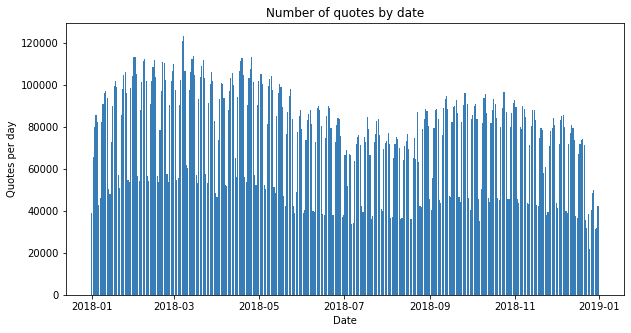

In [ ]:
# Plot the number of quotes by date
plt.figure(figsize=(10, 5))
plt.bar((stats['quotes_by_date']).keys(),
        stats['quotes_by_date'].values(),
        color=COLORS[0]);
plt.title('Number of quotes by date')
plt.ylabel('Quotes per day')
plt.xlabel('Date');

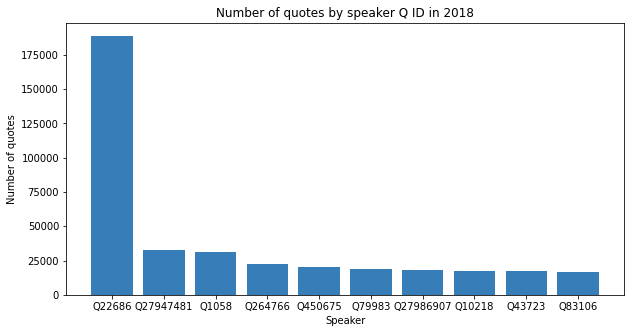

In [ ]:
# Plot the number of quotes for the most common speakers
most_common_qids = stats['qids_count'].most_common(10)
plt.figure(figsize=(10, 5))
plt.bar([t[0] for t in most_common_qids],
        [t[1] for t in most_common_qids],
        color=COLORS[0])
plt.title(f'Number of quotes by speaker Q ID in {YEAR}')
plt.xlabel('Speaker')
plt.ylabel('Number of quotes');

## 2.3.Quote Parsing

The Quotebank data is too large to handle in-memory in a single DataFrame. Therefore, for our initial analyses we select only the quotes from 2018 that were uttered by politicians. We detect these quotes by looking at the Q IDs of the speakers, merging them with Wikidata based on the Q ID, resolving the Q IDs of their profession and filtering those quotes that belong to politicians.

In [ ]:
# A list of politicians of interest.
politicians = ["Barack Obama", "George W. Bush", "Donald Trump", "John McCain",
            "Mitt Romney", "Hillary Clinton", "Benjamin Netanyahu",
            "Narendra Modi", "Joe Biden"]

In [ ]:
# Store politicians data in DataFrame.
# data = pd.read_json(QUOTES_BY_YEAR[YEAR], lines=True)
data = pd.read_json(ARINA_QUTEBANK[YEAR], lines=True)

Below, we look at a couple of quotes that belong to Donald Trump and Barack Obama, two of our politicians of interest.



In [ ]:
trump_quotes = data[data["speaker"].str.contains("Donald Trump")]
trump_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2018-05-08-001245,A constructive deal could easily have been str...,President Donald Trump,[Q22686],2018-05-08 18:36:49,8,"[[President Donald Trump, 0.5633], [None, 0.38...",[http://baynews9.com/fl/tampa/news/2018/05/08/...,E
1,2018-09-26-003692,actually admitted that they're going after far...,President Donald Trump,[Q22686],2018-09-26 00:00:00,138,"[[President Donald Trump, 0.6838], [None, 0.30...",[http://dailyherald.com/news/20180926/kavanaug...,E
3,2018-07-30-004176,always leaves room for negotiation.,President Donald Trump,[Q22686],2018-07-30 20:44:00,4,"[[President Donald Trump, 0.6616], [None, 0.33...",[http://www.10news.com/newsy/trump-25-billion-...,E
4,2018-10-30-005630,an incredible leader who is respected by every...,President Donald Trump,[Q22686],2018-10-30 03:10:00,3,"[[President Donald Trump, 0.358], [Cathy McMor...",[http://m.spokesman.com/stories/2018/oct/30/pr...,E
5,2018-04-21-003582,and he is already a proven liar and leaker.,President Donald Trump,[Q22686],2018-04-21 21:38:52,1,"[[President Donald Trump, 0.7394], [None, 0.16...",[https://mic.com/articles/189012/this-week-in-...,E


In [ ]:
obama_quotes = data[data["speaker"].str.contains("Barack Obama")]
obama_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
21,2018-02-12-035226,I cannot paint.,Barack Obama,[Q76],2018-02-12 13:50:00,2,"[[Barack Obama, 0.8319], [Kehinde Wiley, 0.090...",[http://www.chicagotribune.com/news/ct-obama-p...,E
34,2018-11-03-029313,"incessant, non-stop attempts to divide us with...",Barack Obama,[Q76],2018-11-03 01:43:21,3,"[[Barack Obama, 0.7987], [None, 0.164], [Donal...",[http://thehill.com/homenews/news/414678-obama...,E
96,2018-10-22-004462,All right? I believe in a fact-based reality. ...,President Barack Obama,[Q76],2018-10-22 21:36:28,1,"[[President Barack Obama, 0.7669], [None, 0.21...",[http://www.rawstory.com/2018/10/dont-believe-...,E
156,2018-10-26-096425,The biggest threat to our democracy is cynicis...,President Barack Obama,[Q76],2018-10-26 19:37:30,3,"[[President Barack Obama, 0.8994], [None, 0.08...",[http://cbsnews.com/news/live-stream-obama-ral...,E
179,2018-11-14-125138,was the day I was getting my hair and makeup d...,Barack Obama,[Q76],2018-11-14 16:01:00,1,"[[Barack Obama, 0.7869], [None, 0.2131]]",[http://www.wmagazine.com/story/michelle-obama...,E


##2.4.Quotes and Google Trends

One on of our theories is that politicians talk about subjects of interest. For example, when a major event takes place, we would expect to hear about it in the news, and more importantly, we would expect political stakeholders to talk about it. However, not all politicians may pay the same amount of attention to all events.

We plot the Google search trends against the number of quotes on specific subjects for Donald Trump and Barack Obama, two leaders from opposing parties.

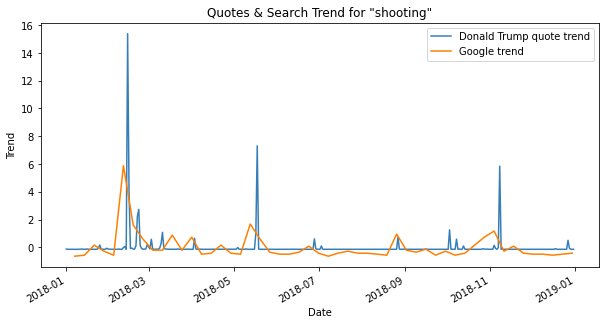

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)
plot_trend(trump_quotes, "shooting", 2018, axs, "Donald Trump")

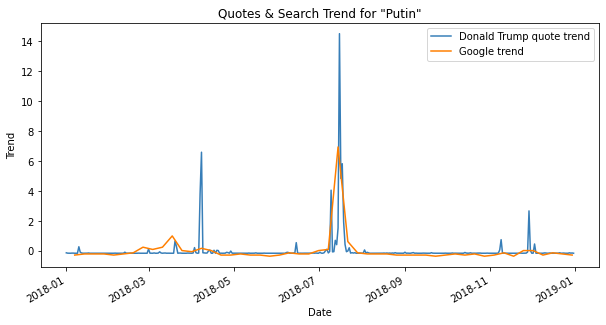

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=1, sharey=True)
plot_trend(trump_quotes, "Putin", 2018, axs, "Donald Trump")

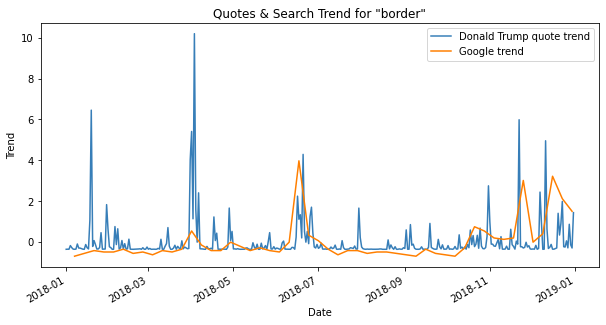

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=1, sharey=True)
plot_trend(trump_quotes, "border", 2018, axs, "Donald Trump")

##2.5.Most common words

We analyze the most common words said by Trump and Obama to see if we can find a pattern. For the current analysis, we only look at the most common nouns of each politician after tokenizing and preprocessing their quotes.

In [ ]:
# Count most common words for Donald Trump
trump_words_cnt = Counter(preprocess_text(" ".join(trump_quotes["quotation"].str.lower())))

In [ ]:
trump_words_cnt.most_common(30)

[('people', 14746),
 ('country', 8374),
 ('president', 6797),
 ('time', 5574),
 ('trump', 5079),
 ('states', 4818),
 ('lot', 4650),
 ('deal', 4224),
 ('world', 4175),
 ('things', 4015),
 ('years', 4005),
 ('trade', 3746),
 ('way', 3711),
 ('something', 3200),
 ('thing', 3179),
 ('countries', 2794),
 ('russia', 2741),
 ('democrats', 2729),
 ('security', 2508),
 ('nothing', 2311),
 ('china', 2304),
 ('border', 2256),
 ('job', 2242),
 ('news', 2217),
 ('money', 2042),
 ('year', 1971),
 ('today', 1946),
 ('house', 1867),
 ('america', 1826),
 ('day', 1824)]

In [ ]:
# Count most common words for Barack Obama.
obama_words_cnt = Counter(preprocess_text(" ".join(obama_quotes["quotation"].str.lower())))

In [ ]:
obama_words_cnt.most_common(30)

[('people', 1585),
 ('time', 654),
 ('president', 577),
 ('world', 574),
 ('way', 533),
 ('country', 533),
 ('politics', 488),
 ('years', 441),
 ('democracy', 419),
 ('things', 402),
 ('work', 359),
 ('power', 343),
 ('something', 325),
 ('life', 323),
 ('america', 320),
 ('obama', 272),
 ('day', 271),
 ('thing', 266),
 ('states', 263),
 ('change', 258),
 ('election', 255),
 ('house', 254),
 ('history', 254),
 ('kind', 247),
 ('vote', 243),
 ('today', 225),
 ('trump', 222),
 ('americans', 212),
 ('women', 211),
 ('man', 204)]

While Donald Trump talks about _Russia_, _China_, _money_, and _democrats_, Barack Obama chooses to talk about _democracy_, _change_, and _work_. This simple approach has revealed that although some of the main nouns are shared between the representants of the two parties, there are also differences that should be futher analyzed to figure out if they can tell us more about their parties.

In [ ]:
# Using this option to display the full quotes
pd.set_option('display.max_colwidth', None)

In [ ]:
obama_quotes[obama_quotes["quotation"].str.contains('gay')]['quotation'].head()

2682     the scene of an uprising against police repres...
17756    (W) hen I hear people say they don't like iden...
28033    I still have to stand here at a lecture and de...
33060    Which is why, by the way, when I hear people s...
42994    One day, to your horror, your problem is one h...
Name: quotation, dtype: object

In [ ]:
trump_quotes[trump_quotes["quotation"].str.contains('gay')]['quotation'].head()

1660                               I cannot vibe with gays
3667     On the surface it may seem like Trump is givin...
13736    has shown himself to be completely shameless w...
21951    It's not just for me. I got out there because ...
26626    Tomorrow marks the 73rd anniversary of the lib...
Name: quotation, dtype: object

In [ ]:
# Resetting the column width
pd.reset_option('display.max_colwidth')

##2.6.News websites and speakers

In [ ]:
# Do not alter original data
new_data_domains = data.copy()
# Convert urls into domain names -> this takes 1 minute
new_data_domains['urls'] = new_data_domains['urls'].apply(get_domain_names)

In [ ]:
# Standardize speaker names in order to be able to group quotes
new_data_domains['speaker'] = new_data_domains['speaker'].apply(standardize_speaker_name)
new_data_domains.head(10)
# Gather all sites that retreieved a politician's quotes
by_politician = new_data_domains.groupby('speaker')['urls'].agg(lambda x: list(chain.from_iterable(x.values))).reset_index()

In [ ]:
# Get number of quotes retrieved by a website, for each politician
politicians_websites = []
for index, row in by_politician.iterrows():
  p_websites = pd.DataFrame(Counter(row['urls']).most_common(5),
                                columns=["Website name", "{}".format(row['speaker'])])
  politicians_websites.append(p_websites)

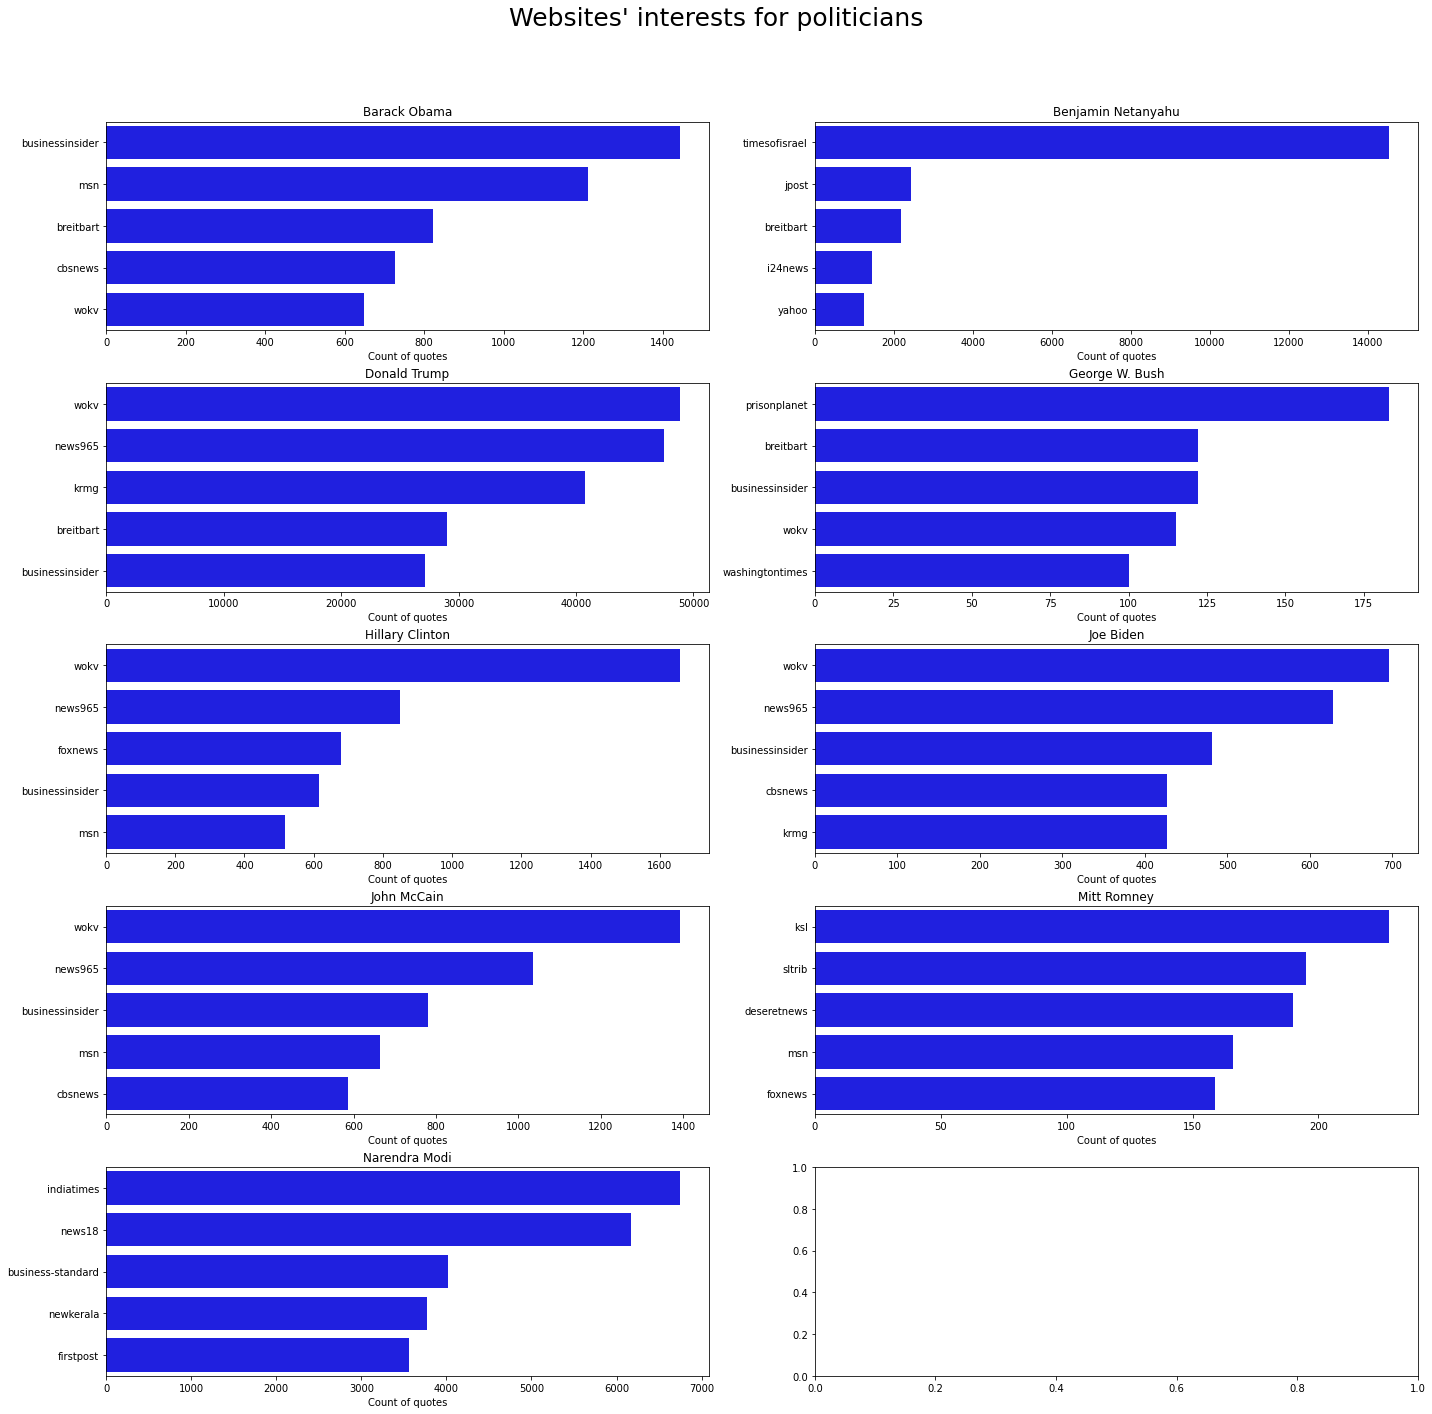

In [ ]:
# Plot the websites, preferences for each politician
w = 2
h = len(politicians_websites) // w + 1
fig, ax = plt.subplots(h, w, figsize=(20, 20))
for i in range(h):
  j = 0
  while i * w + j < len(politicians_websites) and j < w:
    sbplt = ax[i, j]
    ax_sns = sns.barplot(x=politicians_websites[j + i * w].columns[-1], y="Website name", 
                         data=politicians_websites[j + i * w], ax=sbplt, color='blue')#.set(xscale="log")
    ax_sns.set(xlabel="Count of quotes", ylabel=None, title=politicians_websites[j + i * w].columns[-1])
    j += 1
fig.tight_layout()
fig.suptitle("Websites' interests for politicians", fontsize=25)
fig.subplots_adjust(top=0.90)

#3.Quotebank dataset preprocessing 

Our analysis focuses on politicians belonging to one specific party. Therefore, with the help of Wikidata information we apply several prepeocessing steps in order to get a data format suitable for our analysis. 

##3.1.Helper functions
A list of helper functions used throughout the preprocessing steps.

In [7]:
def convert_qcodes(l, df):
  """
  Convert list of qcodes(objects) to labels(strings)
  """
  return 'no_code' if l is None else list(map(lambda x: df.loc[x]['Label'] if x in df.index else 'no_code', l))


def qcodes_tolist(l):
    """
    From list of objects to list of strings
    """
    return list(map(lambda x: x, l))


def infer_format(time_stmp):
    """
    Infer date format.
    """
    if time_stmp[6:8] == '00':
        time_stmp = time_stmp[:5]
        dt_format = '+%Y'
    else:
        time_stmp = time_stmp[:8]
        dt_format = '+%Y-%m'
    return time_stmp, dt_format
    

def get_party_membership(q_code):
    """
    Function for obtaining party membership intervals for speaker with q_code
    """
    tmp = []
    if q_code is not None:
        try:
            s = get_entity_dict_from_api(q_code)
        except:
            return []
        if len(s.get("claims", {}).get("P102", [])) > 0:
            for i, v in enumerate(s["claims"]["P102"]):
                if v["mainsnak"].get("datavalue", {}).get("value", {}).get("id") is not None:
                    party = v["mainsnak"]["datavalue"]["value"]["id"]
                    if party in q_codes_labels.index:
                        party = q_codes_labels.loc[party]['Label']
                        if party is not None:
                            # Separate case when there is only one political party for a speaker
                            # Just consider it as the correct party
                            if len(s["claims"]["P102"]) == 1:
                                tmp.append([party, '+2008-07-31T00:00:00Z', '+2020-05-01T00:00:00Z'])
                                continue
                            start_time, end_time = None, None
                            if len(v.get('qualifiers', {}).get('P580', [])) > 0:
                                if v['qualifiers']['P580'][0].get('datavalue', {}).get("value", {}).get('time') is not None:
                                    start_time = v['qualifiers']['P580'][0]["datavalue"]["value"]["time"]
                            if len(v.get('qualifiers', {}).get('P582', [])) > 0:
                                if v['qualifiers']['P582'][0].get('datavalue', {}).get("value", {}).get('time') is not None:
                                    end_time = v['qualifiers']['P582'][0]["datavalue"]["value"]["time"]
                            # If there are specific start date and end date, take the party into consideration
                            if start_time is not None and end_time is not None:
                                tmp.append([party, start_time, end_time])
                            # If there is a strat date but not end date, consider the end date, the current one
                            elif start_time is not None and end_time is None:
                                tmp.append([party, start_time, '+2020-05-01T00:00:00Z'])
                            else:
                                continue

    if len(tmp) == 0:
        return []

    return tmp


def map_speaker_to_party(qids, year):
    """
    Get list of parties for each speaker using Wikidata API
    """
    speaker_to_parties = {}
    df_speaker_to_parties = pd.DataFrame(index=range(len(qids)))
    df_speaker_to_parties["party"] = ''
    df_speaker_to_parties["qid"] = ''

    for i, qid in tqdm(enumerate(qids)):
        if qid not in speaker_to_parties:
            # Create entry in dict of mappings between politicians and party memberships intervals
            speaker_to_parties[qid] = get_party_membership(qid)
            df_speaker_to_parties.loc[i, 'qid'] = qid

    df_speaker_to_parties.at[list(range(len(qids))), 'party'] = list(speaker_to_parties.values())
    df_speaker_to_parties.to_csv(SPEAKER_TO_PARTY_PATH_CSV[year])


def get_politicians_party(df, pol_to_party):
    """
    Select only one party for each politician
    """
    quote_party = {}
    for i, sample in tqdm(df.iterrows()):
        qid = sample['qids']
        # If we already have the party for a politician
        new_sample = sample
        # Get quote date
        quote_date = datetime.strptime(new_sample['quoteID'][:7], '%Y-%m')
        # Get a politician parties (nan may be encoutered)
        try:
            pol_parties = pol_to_party.loc[qid, 'party'].values[0]
        except:
            pol_parties = []
        tmp = []
        # Select the party membership interval corresponding to the quote date
        for p in pol_parties:
            try:
                # Some dateformats from wikidata may be screwed
                if datetime.strptime(*infer_format(p[1])) <= quote_date < datetime.strptime(*infer_format(p[2])):
                    tmp.append(p[0])
            except:
                continue
        # If multiple parties found take the last one
        if len(tmp) >= 1:
            tmp = tmp[-1]
            quote_party[new_sample['quoteID']] = tmp
            
    return quote_party


def get_politicians_entire_data(year, wiki_politicians, proba_threshold=0.6, sub_samples=None):
    # Given a year, parses the Quotebank data and creates a zip containing
    # the quotes of politicians that belong to a party from that year.

    to_remove_keys = ('numOccurrences', 'phase', 'urls', 'date', 'probas')
    path_to_out = QUOTES_BY_YEAR[year]
    path_to_file = f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2'
    with bz2.open(path_to_file, 'rb') as s_file:
        with bz2.open(path_to_out, 'wb') as d_file:
            for i, instance in tqdm(enumerate(s_file)):
                if sub_samples is not None and i > sub_samples:
                    break
                # Load a sample.
                instance = json.loads(instance)
                # If there is un unknown speaker with the highest probability, 
                # therefore no qids or the attributed speaker has a lower
                # probability than a threshold, then pass. Also keep only politicians
                # with a single qid, to be sure that he is the one who said the quote
                if len(instance['qids']) == 0 or float(instance['probas'][0][1]) < proba_threshold \
                or len(instance['qids']) > 1:
                    continue
                # Remove unnecessary keys
                for key in to_remove_keys:
                    instance.pop(key, None)
                qid = instance['qids'].copy()
    
                # Get corresponding wiki_politicians sample for the specific qid in quotebank
                # This happens only if quotebank speaker is politician in a party
                try:
                    wikidata_sample = wiki_politicians.loc[qid]
                except KeyError:
                    continue
                # Replace qid for politcian
                instance['qids'] = qid
                # Merge quotebank sample with wikidata sample
                instance['party'] = wikidata_sample['party'].values[0]
                instance['party_qcodes'] = wikidata_sample['party_qcodes'].values[0]
                # Write to file
                d_file.write((json.dumps(instance)+'\n').encode('utf-8'))


def no_code_filter(x):
    if set(x) == set(['no_code']):
        return False
    return True

##3.2.Wikidata politicians filtering
Wikidata provides valuable additional information to the one available in Quotebank. Every entry (page) from Wikidata coressponds to a unique **q-code**. Furthermore, each **q-code** could have an assigned **label** which is a single word describing the entry.

The first preprocessing step is to get the mapping between Wikidata q-codes and their labels. We use the already provided .csv file containing this mapping.


In [8]:
# Mapping between wikidata q codes and their labels
q_codes_labels = pd.read_csv(WIKIDATA_LABELS_PATH, compression='bz2', index_col='QID')

In [9]:
# Filter out nan labels
q_codes_labels = q_codes_labels[~q_codes_labels['Label'].isna()]
q_codes_labels.head(3)

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks


Next, we will use the provided *.parquet* file for exploiting Wikidata information. Each entry in the dataframe is a person with several details. These details are provided through the associated **q-codes** describing them. 

Firstly, we aim to keep only the people that belonged to at least one party in their lifetime.

In [ ]:
# Read wikidata .parquet file into a dataframe
wikidata = pd.read_parquet(WIKIDATA_PATH, engine='pyarrow').set_index('id')
# Filter out nan values
wikidata = wikidata[~wikidata['party'].isna()]
wikidata['party_qcodes'] = wikidata['party']
wikidata.head()

We are interested in each person's occupation and political party. Thus, using the *q-code to label* mapping, we transform the q-codes to string representations.

In [ ]:
# Map Wikidata party and occupation qcodes to labels
wikidata_qcodes = wikidata[WIKIDATA_QCODES_COL].progress_applymap(lambda lst: convert_qcodes(lst, q_codes_labels))
wikidata = pd.concat([wikidata_qcodes, wikidata['party_qcodes']], axis=1)
wikidata['party_qcodes'] = wikidata['party_qcodes'].apply(lambda lst: qcodes_tolist(lst))
wikidata.head(3)

Having each person's occupations represented as a list of strings, we keep only the people that are politicians.

In [ ]:
# Keep only Wikidata's politicians
wikidata_politicians = wikidata.loc[wikidata['occupation'].apply(lambda lst: 'politician' in str(lst))]
wikidata_politicians.head(3)

In [ ]:
# Total number of Wikidata politicians
wikidata_politicians.shape

In [ ]:
# Save table with wikidata politicians
wikidata_politicians.to_csv('/content/drive/MyDrive/wikidata_politicians.csv')

This preprocessing step represents the Wikidata dataset filtering. We now have a dataframe containing all politicians from Wikidata belonging to at least one party.

##3.3.Quotebank politicians filtering
The next step consists of enriching Qutebank dataset with the previous filtered Wikidata dataset. For each entry in Quotebank we will add the occupation and political parties of the speaker associated with the quote.

In [18]:
# Read dataframe with Wikidata politicians
wikidata_politicians = pd.read_csv(WIKIDATA_POLITICIANS_PATH).set_index('id')

One problem is that in the *q-codes to label* mapping, not all q-codes have a label because of Wikidata's inconsistency or because some Wikidata q-codes are simply missing from the provided mapping file. We will filter out all the parties (in 'party' column) and their q_codes (in 'party_qcodes' column) that could not be associated with an existing label, as we are interested in the parties' names. Thus, we will form a dataframe where for each politician in the Wikidata dataset there will be a list of labeled parties (and their q_codes) that he/she belonged to. 

In [19]:
# Filter out Wikidata politicians where no label was assigned for their party
wikidata_politicians = wikidata_politicians.loc[wikidata_politicians['party'].apply(lambda x: x != 'no_code')]

In [20]:
# Transform a string representing a list to la list of strings
wikidata_politicians['party'] = wikidata_politicians['party'].apply(lambda x: ast.literal_eval(x))
wikidata_politicians['party_qcodes'] = wikidata_politicians['party_qcodes'].apply(lambda x: ast.literal_eval(x))

In [ ]:
# Remove entries without a party
wikidata_politicians_in_party = wikidata_politicians[wikidata_politicians['party'].apply(lambda x: no_code_filter(x))]
wikidata_politicians_in_party_names = wikidata_politicians_in_party['party']
wikidata_politicians_in_party_qcodes = wikidata_politicians_in_party['party_qcodes']
# Remove nan party names and their corresponding q_codes
for i, parties in enumerate(wikidata_politicians_in_party_names):
    if 'no_code' in parties:
        idx = parties.index('no_code')
        wikidata_politicians_in_party_names[i].pop(idx)
        wikidata_politicians_in_party_qcodes[i].pop(idx)
wikidata_politicians_in_party['party'] = wikidata_politicians_in_party_names
wikidata_politicians_in_party['party_qcodes'] = wikidata_politicians_in_party_qcodes
wikidata_politicians_in_party.head()

The next step is to merge the current Wikidata information with Quotebank dataset, through the 'Get_politicians_entire_data()' function. We will apply the next filterings when merging:

1.   Keep only quotes that have a specific speaker as the most probable to have said a quote -> we remove quotes that have an unknown speaker attributed with the highest probability.
2.   Keep only quotes where the main attributed speaker have a probability above a specified threshold (0.6) -> in this way we will be sure that the quote will truly belong to that speaker
3.   Keep quotes that have only one attributed speaker -> in Quotebank dataset the 'qids' field represent Wikidata IDs of all aliases that match the selected speaker. Therefore, a quote is attributed to a list of speakers with the same name. It may happen that this list also contains different politicians with the same name, thus, we won't be able to decide who actually said the quote. In order to address this problem, we simply remove quotes that have more than one element in the 'qids' field as we want to be sure that the current quote is belonging to one specific politician. 



In [ ]:
# Create zipped file for a specific year, with all Quotebank's entries where
# the speaker is a politician belonging to at least one party
get_politicians_entire_data(YEAR, wikidata_politicians_in_party, proba_threshold=0.6)

##3.4.Further Quotebank filtering


###3.4.1.Only one party for each speaker

In the previous step we made sure that a quote belongs to only one specific politician. In order to have a robust analysis, we would like to assign only one political party to each politician. In the currently created dataset, each speaker has a list of parties to which he belonged to throughout his life. By using a Wikidata API, namely **qwikidata**, we are able to retrieve the membership time interval for each of the speaker's parties.

Firstly, we will consider all the unique qids in the dataset and compute a mapping between a speaker and his parties membership intervals. We will access the Wikidata's *start date* and *end date* corresponding to a specific party membership (only if they are available, otherwise we will not take into consideration the specific party)

Secondly, for each speaker we will keep only one political party by the next logic:

1.   If a speaker belonged to only one political party throughout their life, we associate that party with their quotes, regardless of the date.
2.   If a speaker belonged to multiple parties, we aim to select the party they were part of at the time of the quotation -> we will extract the quotation date from the 'quoteID' filed in Quotebank. NOTE: Some Wikidata membership intervals may be screwed, having an unparsable format, thus, we simply consider those as inexistent. 

The unique party will be stored in 'party_one' column of the dataframe.



In [23]:
# Read the Quotebank data just created
quotebank_data = pd.read_json(QUOTES_BY_YEAR[YEAR], lines=True)
quotebank_data.head()

,quoteID,quotation,speaker,qids,party,party_qcodes
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],[Republican Party],[Q29468]
1,2020-03-19-000276,[ These ] actions will allow households who ha...,Ben Carson,[Q816459],"[Republican Party, Democratic Party, independe...","[Q29468, Q29552, Q327591, Q29468]"
2,2020-03-12-000358,1. FM is entitled to go straight to press conf...,Paul Masterton,[Q30164281],[Scottish Conservatives],[Q3243587]
3,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,[Q771586],[Democratic Party],[Q29552]
4,2020-04-11-000477,a manufacturer here in the state of California.,Gavin Newsom,[Q461391],[Democratic Party],[Q29552]


In [ ]:
# Get party intervals for each speaker and save dataframe to csv
quotebank_qids = set(chain.from_iterable(quotebank_data['qids'].values))
map_speaker_to_party(quotebank_qids, YEAR)

In [28]:
# Read dataframe with mapping between speaker and parties
politician_to_party = pd.read_csv(SPEAKER_TO_PARTY_PATH_CSV[YEAR]).drop(columns='Unnamed: 0').set_index('qid')
politician_to_party["party"] = politician_to_party["party"].apply(lambda x: ast.literal_eval(x))
politician_to_party.head(5)

,party
qid,
Q19892165,"[[Sinn Féin, +2008-07-31T00:00:00Z, +2020-05-0..."
Q465041,"[[All India Trinamool Congress, +1997-01-01T00..."
Q3037187,[[Progressive Conservative Party of New Brunsw...
Q20830739,"[[SYRIZA, +2012-00-00T00:00:00Z, +2020-05-01T0..."
Q28967776,"[[Suheldev Bharatiya Samaj Party, +2008-07-31T..."


In [29]:
# Get a dictionry where each politicians is assigned to one party
quotebank_copy = quotebank_data.copy()
quote_to_one_party = get_politicians_party(quotebank_copy, politician_to_party)

597171it [07:27, 1334.03it/s]


In [30]:
# Create a new dataframe from the obtained dictionary and merge with Quotebank
one_party_df = pd.DataFrame.from_dict(quote_to_one_party, orient='index', columns=['party'])
quotebank_copy = quotebank_copy.merge(one_party_df, how='inner', left_on='quoteID', right_index=True, suffixes=('', '_one'))

In [31]:
# Write final dataset to csv file
quotebank_copy.to_csv(QUOTEBANK_ONE_PARTY[YEAR])

###3.4.2.Filter similar names

There is still one more issue with the newly created dataframe. A speaker may appear under similar names. For example "President Donald Trump" and "Donald Trump" are two different aliases for the same person (same 'qid'). We address this problem in the following way: 

1.   For each unique < 'qid', 'party_one' > pair we aggregate all speaker's names in a list.
2.   We consider the unique speaker name as the most frequent name appearing in each of the formed list. 






In [32]:
# Read Quotebank dataset
quotebank_one_party = pd.read_csv(QUOTEBANK_ONE_PARTY[YEAR], index_col=[0])
quotebank_one_party.head()

,quoteID,quotation,speaker,qids,party,party_qcodes,party_one
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,['Q367796'],['Republican Party'],['Q29468'],Republican Party
1,2020-03-19-000276,[ These ] actions will allow households who ha...,Ben Carson,['Q816459'],"['Republican Party', 'Democratic Party', 'inde...","['Q29468', 'Q29552', 'Q327591', 'Q29468']",Republican Party
2,2020-03-12-000358,1. FM is entitled to go straight to press conf...,Paul Masterton,['Q30164281'],['Scottish Conservatives'],['Q3243587'],Scottish Conservatives
3,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,['Q771586'],['Democratic Party'],['Q29552'],Democratic Party
4,2020-04-11-000477,a manufacturer here in the state of California.,Gavin Newsom,['Q461391'],['Democratic Party'],['Q29552'],Democratic Party


In [33]:
# Filter speaker similar names
quotebank_by_qid_and_party = quotebank_one_party.groupby(['qids', 'party_one']).agg(list)
for i, row in quotebank_by_qid_and_party.iterrows():
    if len(set(row['speaker'])) > 1:
        name = list(sorted(Counter(row['speaker']).items(), key=lambda x: x[1], reverse=True))[0][0]
    else:
        name = list(set(row['speaker']))[0]
    quotebank_by_qid_and_party.loc[i]['speaker'] = name

quotebank_by_qid_and_party = quotebank_by_qid_and_party[['speaker']]

In [34]:
# Create new filtered Quotebank where similar speaker names will be considered as one
new_quotebank = quotebank_one_party.merge(quotebank_by_qid_and_party, how='inner', left_on=['qids', 'party_one'], right_index=True, suffixes=('_before', ''))
new_quotebank = new_quotebank.drop(columns='speaker_before')

In [35]:
# Write final dataset to file
new_quotebank.to_csv(QUOTEBANK_ONE_PARTY[YEAR])

#4.Analysis on the filtered Quotebank dataset
Our final version of filtered Quotebank dataset has the next format:


*   ```quoteID``` : Primary key of the quotation (format: "YYYY-MM-DD-{increasing int:06d}")
*   ```quotation``` : Text of the longest encountered original form of the quotation
*   ```qids``` : Single and unique speaker q-code
*   ```party``` : List of all parties which a speaker belonged to
*   ```part_qcodes``` : List of q-codes associated to a speaker's parties
*   ```part_one``` : The party which a speaker was part of at time of quotation
*   ```speaker``` : General speaker name







In [44]:
# Read filtered quotebank dataset
quotebank_one_party = pd.read_csv(QUOTEBANK_ONE_PARTY[YEAR], index_col=[0])
quotebank_one_party.head()

,quoteID,quotation,qids,party,party_qcodes,party_one,speaker
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,['Q367796'],['Republican Party'],['Q29468'],Republican Party,Sue Myrick
212172,2020-01-16-012811,cancel contracts to train Saudi police and oth...,['Q367796'],['Republican Party'],['Q29468'],Republican Party,Sue Myrick
261232,2020-01-16-094237,to block the sale of sensitive military munitions,['Q367796'],['Republican Party'],['Q29468'],Republican Party,Sue Myrick
285821,2020-02-28-013721,enlisted the help of Hezbollah,['Q367796'],['Republican Party'],['Q29468'],Republican Party,Sue Myrick
292725,2020-02-28-034001,implies a Persian influence that can likely be...,['Q367796'],['Republican Party'],['Q29468'],Republican Party,Sue Myrick


##4.1.Parties per year


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


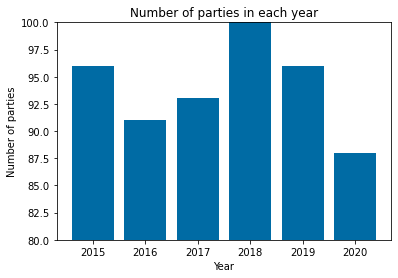

In [62]:
# Get the number of parties for each year
nr_parties = []
plt.style.use('tableau-colorblind10')
for year in YEARS:
    quotebank_one_party = pd.read_csv(QUOTEBANK_ONE_PARTY[year], index_col=[0])
    parties = len(set(chain.from_iterable(quotebank_one_party['party_one'].values)))
    nr_parties.append(parties)
plt.bar(YEARS, nr_parties)
plt.xlabel("Year")
ax = plt.gca()
ax.set_ylim([80, 100])
plt.ylabel("Number of parties")
plt.title("Number of parties in each year")
plt.show()

##4.2.Quotes per party
Count the number of quotes for each party and output the 10 most influential ones.

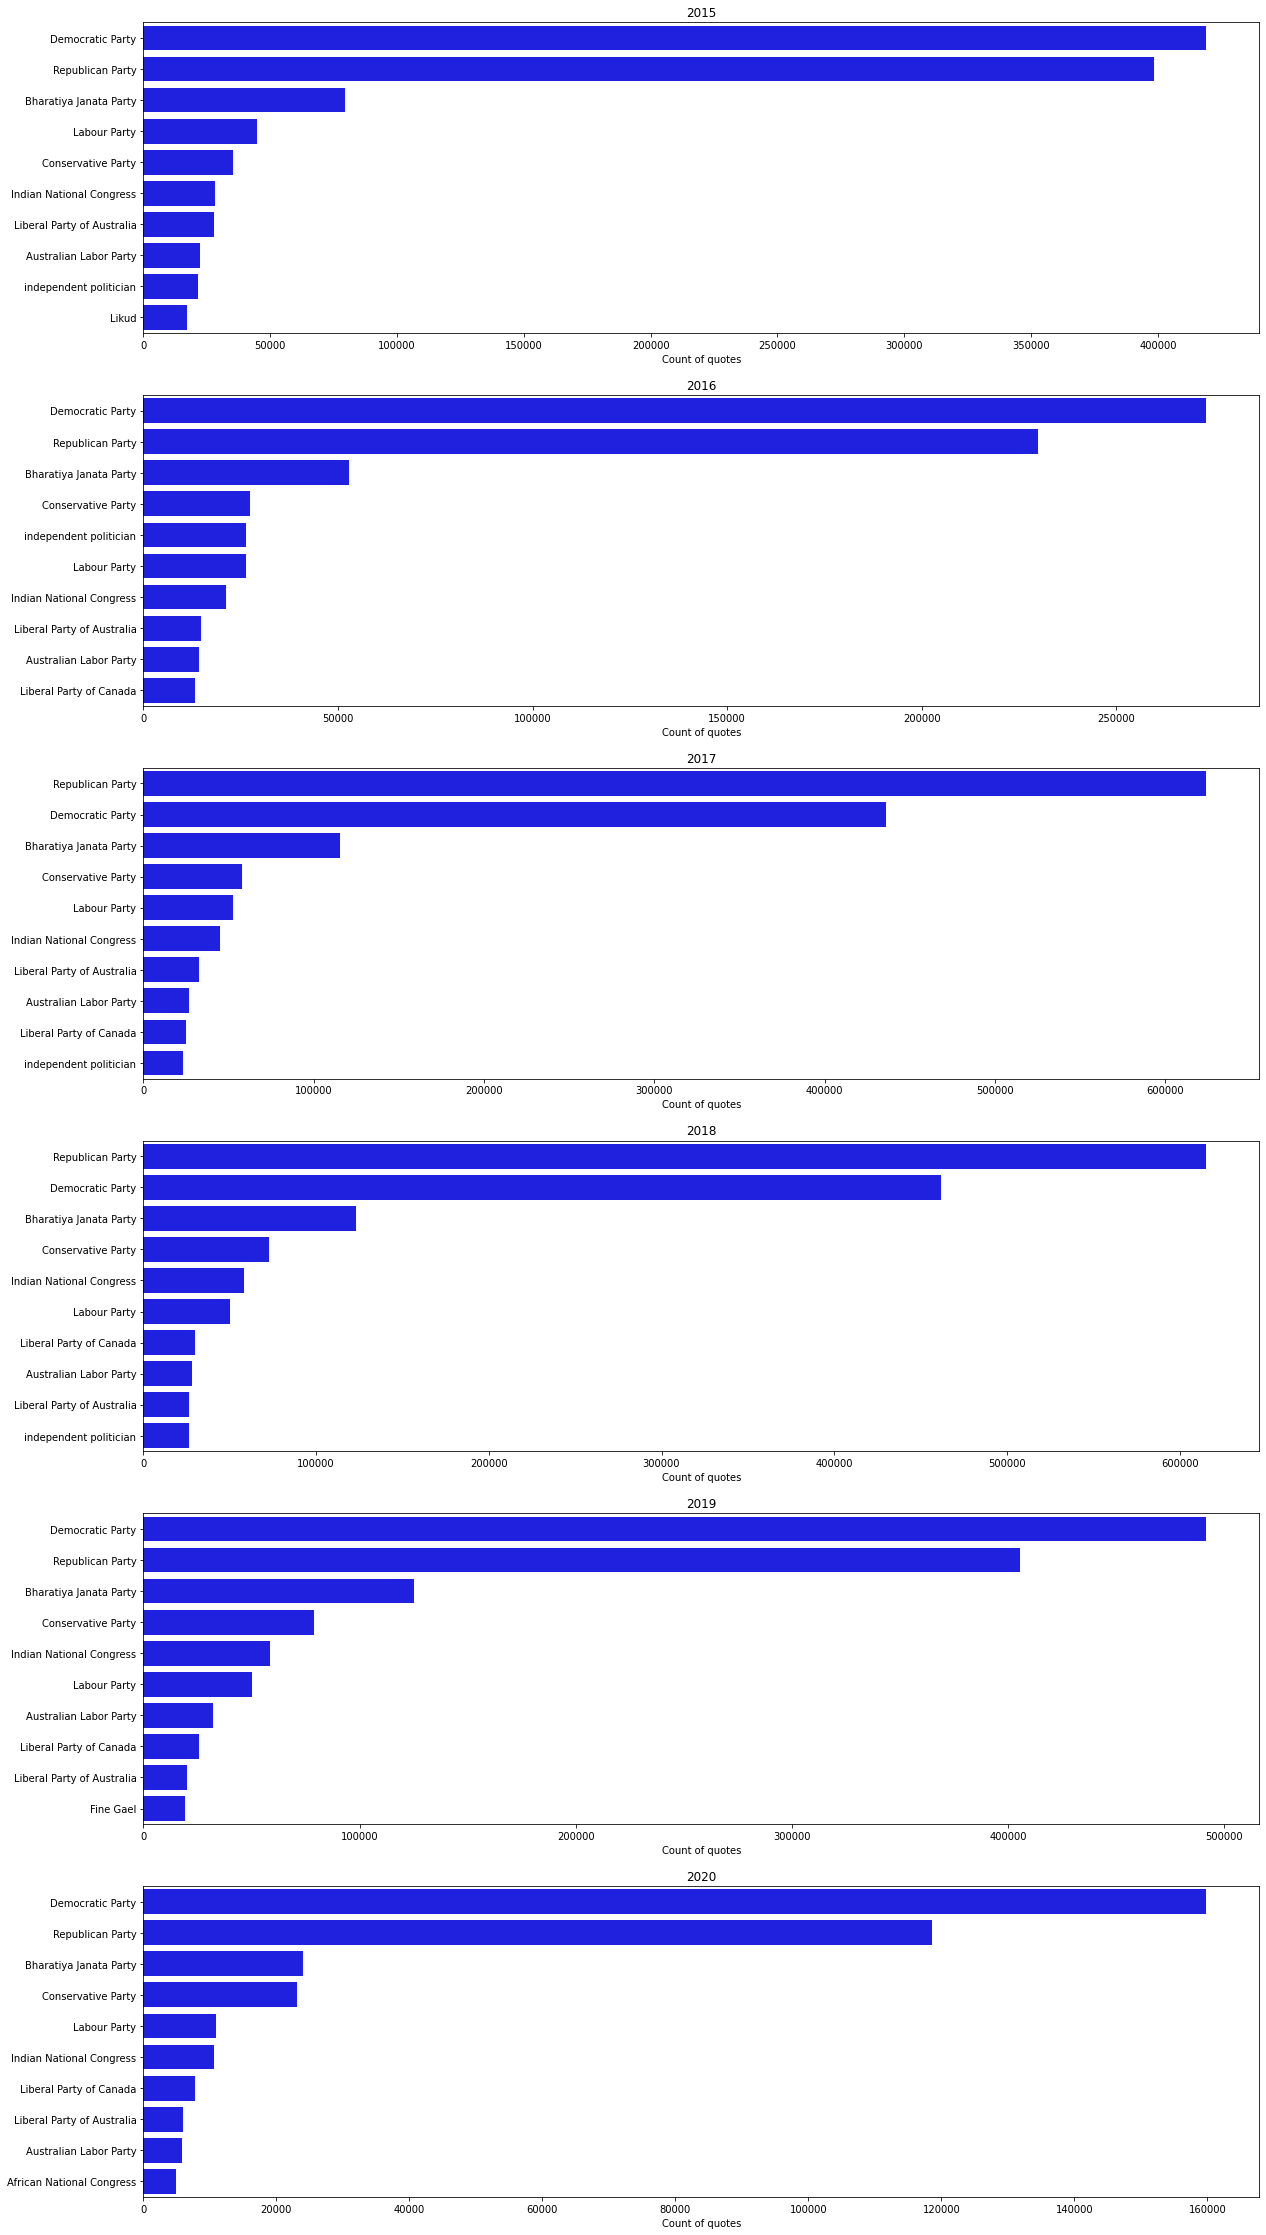

In [78]:
# Parties with the most quotes
fig, axis = plt.subplots(len(YEARS), 1, figsize=(20, 40))#, sharex=True)
for i, year in enumerate(YEARS):
    quotebank_one_party = pd.read_csv(QUOTEBANK_ONE_PARTY[year])
    parties_quotes_one_party_nr = Counter(quotebank_one_party['party_one'].values)
    sorted_parties_quotes_one_party_nr = list(sorted(parties_quotes_one_party_nr.items(), key=lambda x: x[1], reverse=True))
    df_sorted_parties_quotes_one_party_nr = pd.DataFrame(sorted_parties_quotes_one_party_nr, columns=['Party', 'Number of quotes']).head(10)
    ax_sns = sns.barplot(x='Number of quotes', y="Party", 
                         data=df_sorted_parties_quotes_one_party_nr, ax=axis[i], color='blue')
    # ax_sns.set(xscale="log")
    ax_sns.set(xlabel="Count of quotes", ylabel=None, title=str(year))

##4.3.Quotes per politician
Count the number of quotes per politician.

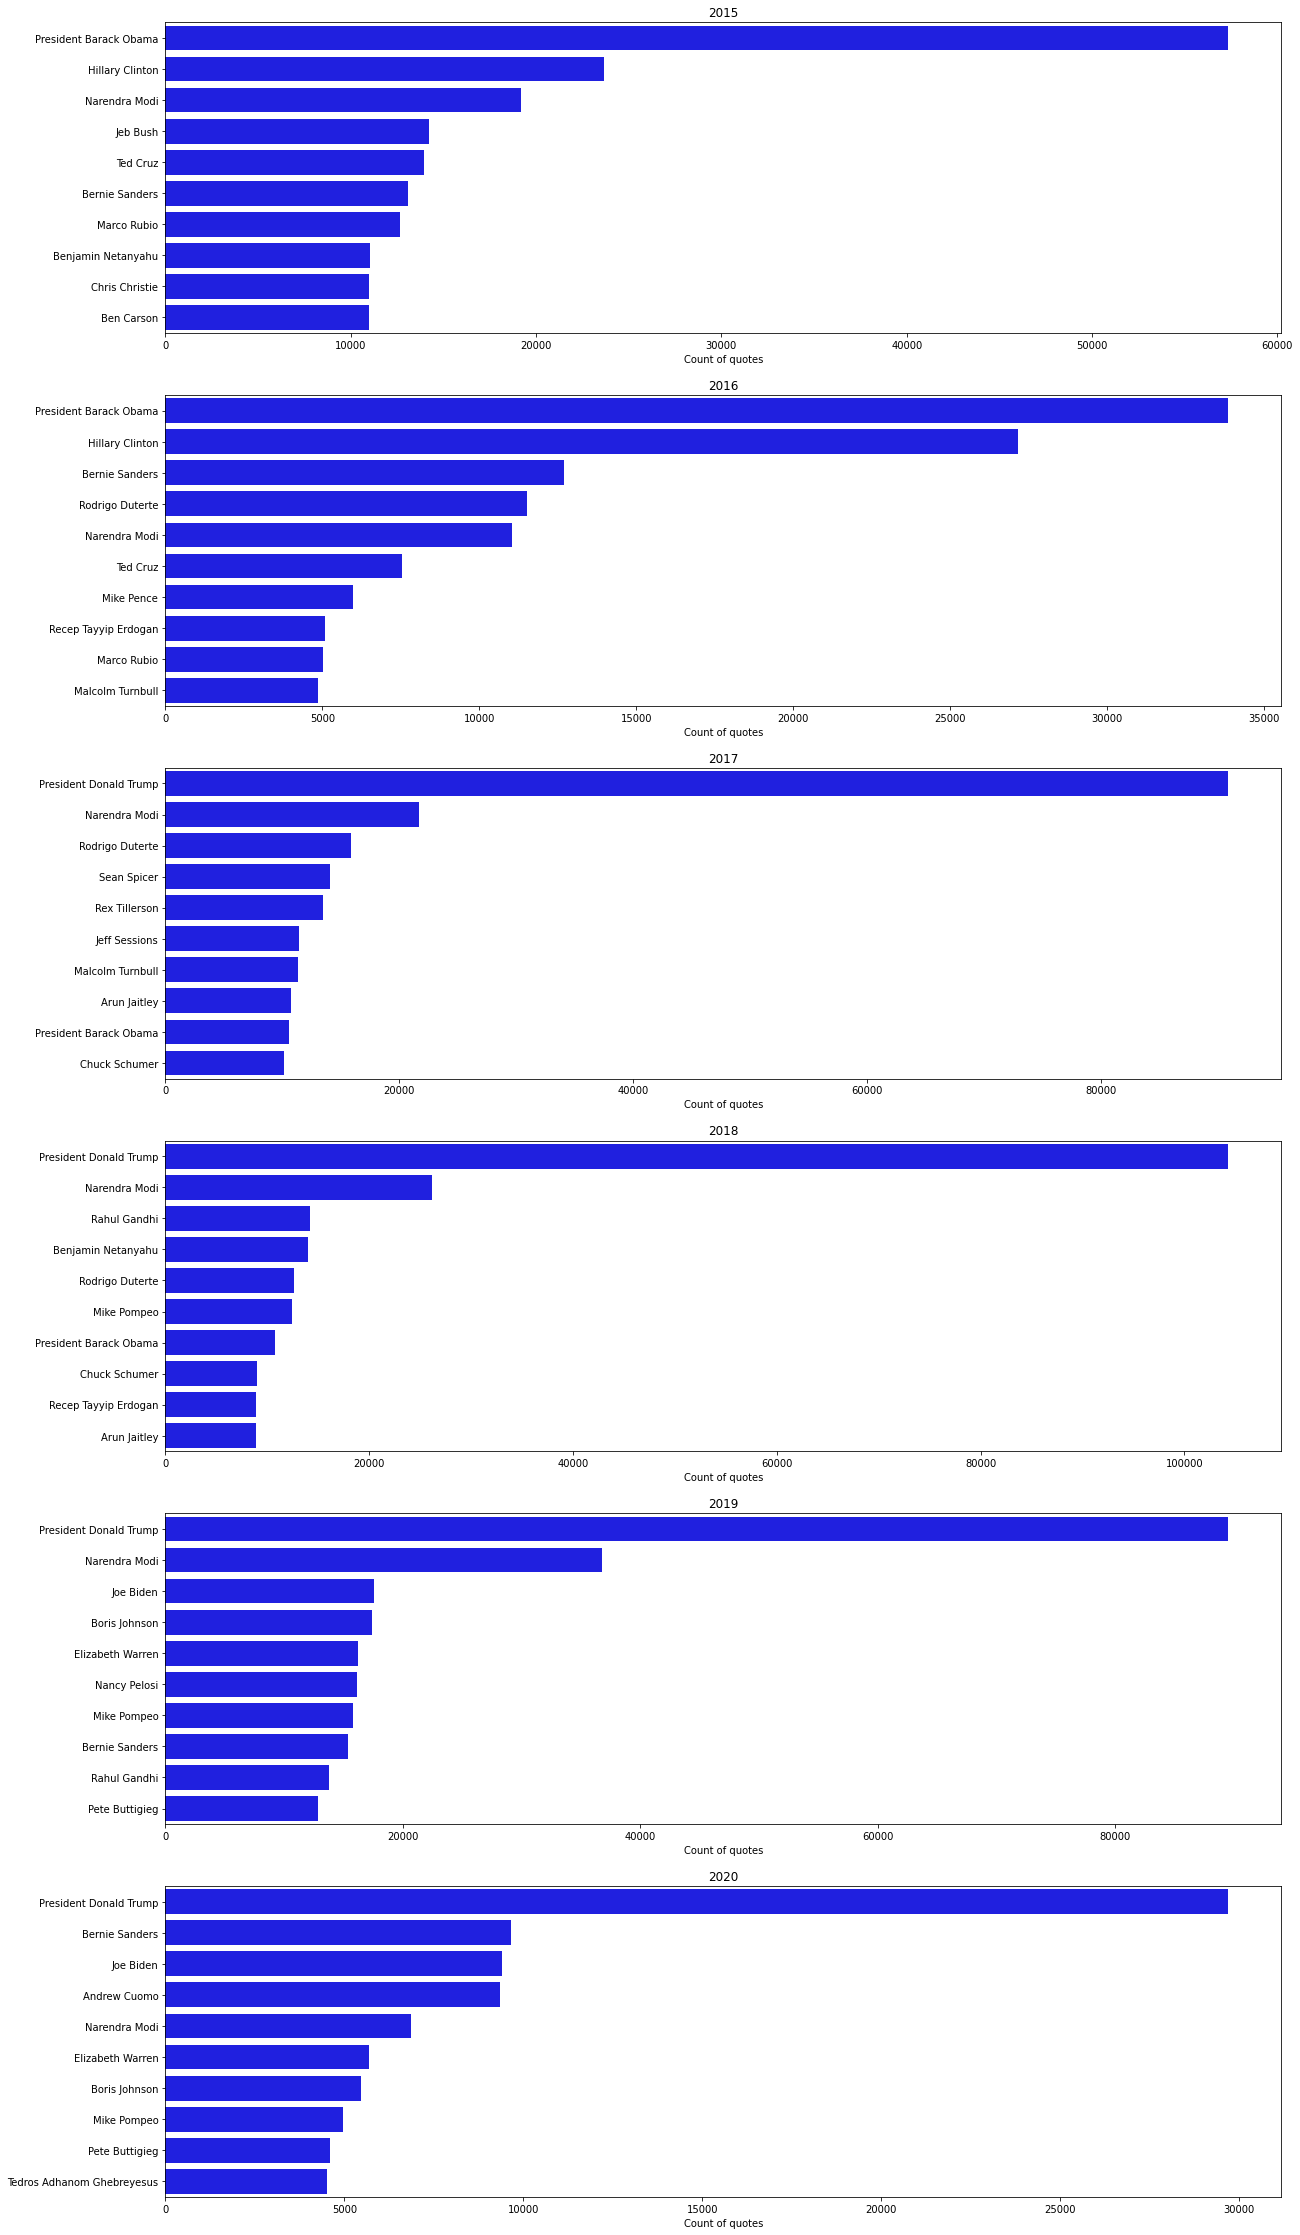

In [79]:
# Number of quotes by politician (most influential)
fig, axis = plt.subplots(len(YEARS), 1, figsize=(20, 40))#, sharex=True)
for i, year in enumerate(YEARS):
    quotebank_one_party = pd.read_csv(QUOTEBANK_ONE_PARTY[year])
    quotes_by_politician_one_party = quotebank_one_party.groupby('speaker')['quotation'].count()
    quotes_by_politician_one_party = quotes_by_politician_one_party.sort_values(ascending=False)
    df_quotes_by_politician_one_party = pd.DataFrame(quotes_by_politician_one_party).reset_index().rename(columns={"quotation": "number of quotes"}).head(10)
    ax_sns = sns.barplot(x='number of quotes', y="speaker", 
                         data=df_quotes_by_politician_one_party, ax=axis[i], color='blue')
    # ax_sns.set(xscale="log")
    ax_sns.set(xlabel="Count of quotes", ylabel=None, title=str(year))

#5.Clustering

##5.1.Setup

In [ ]:
# Check cuda runtime and set model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer('bert-base-nli-mean-tokens')
print(device)

##5.2.Form clusters

In [ ]:
# Get a subset of quotebank
quotebank_subset = quotebank_one_party[:10000]

In [ ]:
# Find sentence embeddings
sentence_embeddings = model.encode(list(quotebank_subset['quotation']), show_progress_bar=True)
# Reduce dimensionality of embeddings
umap_embeddings = umap.UMAP(n_neighbors=50, n_components=9, metric='cosine').fit_transform(sentence_embeddings)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
# Cluster documents
cluster = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


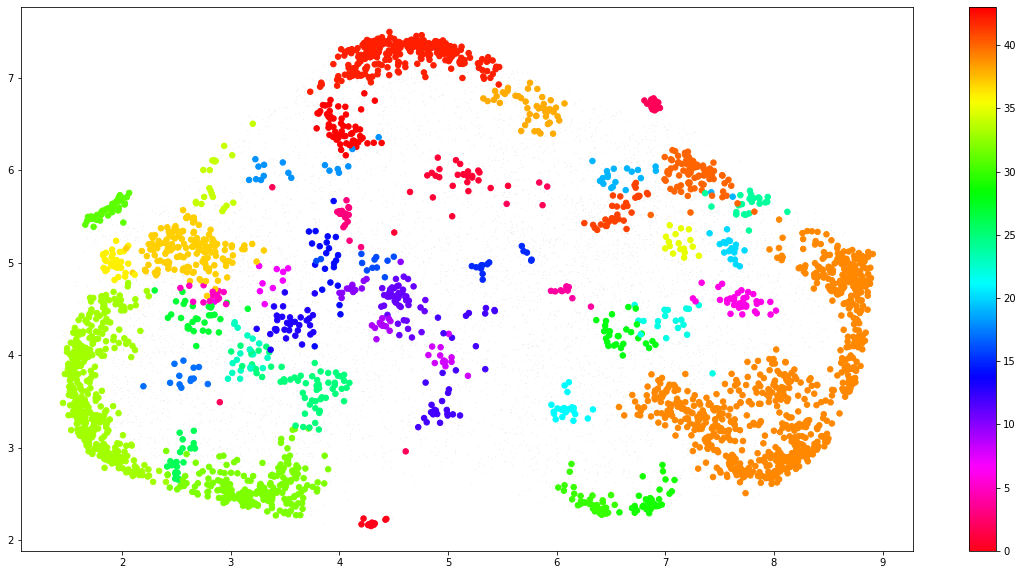

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.0, metric='cosine').fit_transform(sentence_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_
quotebank_subset['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.005)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=30, cmap='hsv_r')
plt.colorbar()

##5.3.Cluster analysis

In [ ]:
# Check a cluster results
clusters = quotebank_subset.groupby('labels')[['quotation', 'party_one']].agg(list)
clusters.quotation.loc[7]

['Northern Ireland ticked all the boxes. These factors, combined with the offer of support from government, made it the logical choice.',
 'Establishment of new party and unification between parties is a natural process in parliamentary democracy. Congratulation and best wishes for unification between CPN (UML) and CPN (Maoist Centre).',
 'I am going with smile to Delhi and would return with smile from Delhi. Today it is a big day for us and state and whatever decision is taken will be good. The high command had given me responsibility to bring Congress back to power and now whatever, responsibility the party will assign will discharge it honestly.',
 'I have myself risen from grass-root level and understand Delhi has best skilled political workers. I appeal to party workers to increase their political moral authority and work to make politics a medium to serve the people,',
 'If today we have a chaiwala as prime minister, it is because Nehru created the institutional structures throug

In the clusters below, the hdb scan algorithm assigns label of -1 to quotes that could not be clustered

In [ ]:
# Show which parties talk the most about a specific topic
pp = pprint.PrettyPrinter(indent=4)
for label, row in clusters.iterrows():
    if label != -1:
        party_counts = Counter([x for x in row['party_one']])
        print(f'Parties most interested in topic {label}:')
        pp.pprint(list(sorted(party_counts.items(), key=lambda x: -x[1])))

Parties most interested in topic 0:
[   ('Liberal Party of the Philippines', 6),
    ('Partido Demokratiko Pilipino–Lakas ng Bayan', 3),
    ('Muungano Party', 1),
    ('Bharatiya Janata Party', 1),
    ('Malaysian United Indigenous Party', 1),
    ("Akbayan Citizens' Action Party", 1),
    ('Nacionalista Party', 1),
    ('National Unity Party', 1),
    ('United Nationalist Alliance', 1)]
Parties most interested in topic 1:
[   ('Democratic Party', 9),
    ('Republican Party', 5),
    ('Malaysian United Indigenous Party', 1),
    ('Minnesota Democratic–Farmer–Labor Party', 1),
    ('California Democratic Party', 1),
    ('British Columbia Liberal Party', 1),
    ('Democratic Action Party', 1),
    ('Australian Labor Party', 1),
    ('Parti libéral du Québec', 1),
    ('Bharatiya Janata Party', 1),
    ('New Zealand Labour Party', 1),
    ('Christian Democracy', 1),
    ('All India Trinamool Congress', 1),
    ("Nationalist People's Coalition", 1),
    ('Party of National Unity', 1)]
Pa